<a href="https://colab.research.google.com/github/Prabhitha/FakeNewsDetection/blob/main/FakeNewsDetection_TFIDF_Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the TFIDF- Vectorized data on different Machine Learning models
###1. Logistic Regression
###2. Linear SVM
###3. Gradient Boosted Decision Tree(GBDT)
###4. Random Forest

In [ ]:
#Importing Libraries

import warnings
warnings.filterwarnings('ignore')

import os
import re
import spacy
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.manifold import TSNE
from prettytable import PrettyTable
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import BorderlineSMOTE 
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier 

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


%matplotlib inline
sns.set(style="whitegrid")
colors = sns.color_palette()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load the Pre-processed data

if os.path.isfile('/content/drive/My Drive/Fake News Detection/cleaned_featurized_train.csv'):
  train_data = pd.read_csv('/content/drive/My Drive/Fake News Detection/cleaned_featurized_train.csv')
  train_labels = np.load('/content/drive/My Drive/Fake News Detection/train_labels.npy')
 
  test_data = pd.read_csv('/content/drive/My Drive/Fake News Detection/cleaned_featurized_test.csv')
  test_labels = np.load('/content/drive/My Drive/Fake News Detection/test_labels.npy')

In [ ]:
print(train_data.shape)
train_data.head()

(31428, 2)


,text,label
0,first hand account happen baltimor shock unrea...,0
1,meanwhil american afford take singl vacat judi...,0
2,despit tough talk intern affair slam democrat ...,0
3,hell frozen cnn actual report truth cnn legal ...,0
4,madrid reuter head catalan region govern sunda...,1


In [ ]:
# Encoding questions as unicode
train_data['text'] = train_data['text'].apply(lambda x: str(x))
test_data['text'] = test_data['text'].apply(lambda x: str(x))

## TF - IDF embedding
Let's try simple TF-IDF vectors with 5000 features.

In [ ]:
# Initialize vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))

# Vectorizing news
print('Vectorizing News')
tfidf_train = vectorizer.fit_transform(train_data['text'].values)
tfidf_test = vectorizer.transform(test_data['text'].values)

print('Converting to DataFrames')
q_tfidf_train = pd.DataFrame.sparse.from_spmatrix(tfidf_train)
q_tfidf_test = pd.DataFrame.sparse.from_spmatrix(tfidf_test)

print("Train data:", q_tfidf_train.shape)
print("Test data:", q_tfidf_test.shape)

Vectorizing News
Converting to DataFrames
Train data: (31428, 5000)
Test data: (13470, 5000)


In [ ]:
# features
vectorizer.get_feature_names()[2000:2010]

['heart',
 'heat',
 'heavi',
 'heavili',
 'hedg',
 'hedg fund',
 'height',
 'held',
 'helicopt',
 'hell']

In [ ]:
q_tfidf_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.024395,0.0,0.0,0.0,0.000000,0.023321,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.034921,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.022693,0.0,0.0,0.025288,0.022099,0.0,0.0,0.0,0.000000,0.0,0.024941,0.026912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.045519,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.051129,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
q_tfidf_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31428 entries, 0 to 31427
Columns: 5000 entries, 0 to 4999
dtypes: Sparse[float64, 0](5000)
memory usage: 54.4 MB


In [ ]:
print("Number of data points in train data :",q_tfidf_train.shape)
print("Train labels :",train_labels.shape)

print("Number of data points in test data :",q_tfidf_test.shape)
print("Test labels :",test_labels.shape)

Number of data points in train data : (31428, 5000)
Train labels : (31428,)
Number of data points in test data : (13470, 5000)
Test labels : (13470,)


### Creating data matrices

In [ ]:
# First, let's standardize our features.

# Initialize StandardScaler
scaler = StandardScaler(with_mean=False)

# Train data
model_train_std = scaler.fit_transform(q_tfidf_train)

# Test data
model_test = scaler.transform(q_tfidf_test)

In [ ]:
# Balancing the train data
print("Train data before upsampling : ", sorted(Counter(train_labels).items()))

sm = BorderlineSMOTE(random_state=2)
model_train, train_labels = sm.fit_resample(model_train_std, train_labels.ravel())
print('Resampled dataset shape %s' % Counter(train_labels))

Train data before upsampling :  [(0, 16436), (1, 14992)]
Resampled dataset shape Counter({0: 16436, 1: 16436})


### Visualization using t-SNE:

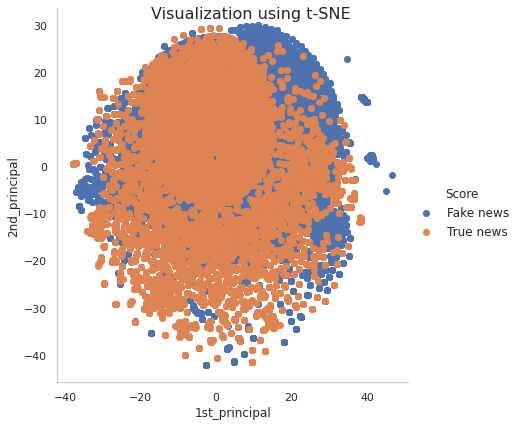

In [ ]:
# TSNE

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=1000)
tsne_data = model.fit_transform(model_train)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, train_labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Fake news', 'True news']

# Ploting the result of tsne
g= sns.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, "1st_principal", "2nd_principal")  \
                                          .add_legend(labels = new_labels, loc=5, fontsize=12)

g.fig.suptitle('Visualization using t-SNE', fontsize=16)
g.ax.grid(False)
plt.show()

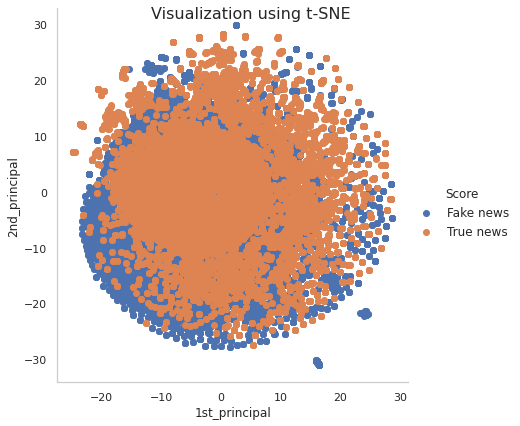

In [ ]:
# TSNE

model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=1000)
tsne_data = model.fit_transform(model_train)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, train_labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Fake news', 'True news']

# Ploting the result of tsne
g= sns.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, "1st_principal", "2nd_principal")  \
                                          .add_legend(labels = new_labels, loc=5, fontsize=12)

g.fig.suptitle('Visualization using t-SNE', fontsize=16)
g.ax.grid(False)
plt.show()

### 4.4 Building a random model (Finding worst-case log-loss)

Defining function to print confusion matrices

In [ ]:
def plot_confusion_matrices(true, pred):
  # Normal confusion matrix
  conf = confusion_matrix(true, pred)
  
  # Precision matrix
  # Precision: Out of all the points predicted of class 'A', how many are actually class 'A'
  # A column in the confusion matrix represents the data points predicted as the same class
  # So we divide all data points by the sum of points in their respective columns
  precision = (conf.T / conf.sum(axis=1)).T

  # Recall matrix
  # Recall: Out of all the points which are of class 'A', how many were predicted to be of class 'A'
  # A row in the confusion matrix represents the data points of the same class
  # So we divide all data points by the sum of points in their respective rows
  recall = (conf / conf.sum(axis=0))

  # Plotting the matrices
  plt.figure(figsize=(24,6))

  # Set axes labels
  labels = ['0', '1']

  # Set colourmap
  cmap = sns.light_palette('purple')

  # Plot normal confusion matrix
  plt.subplot(1, 3, 1)
  sns.heatmap(conf, cmap=cmap, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')

  # Plot precision confusion matrix
  plt.subplot(1, 3, 2)
  sns.heatmap(precision, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Precision Matrix')

  # Plot recall confusion matrix
  plt.subplot(1, 3, 3)
  sns.heatmap(recall, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Recall Matrix')

  plt.show()

## Model 1

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.89069



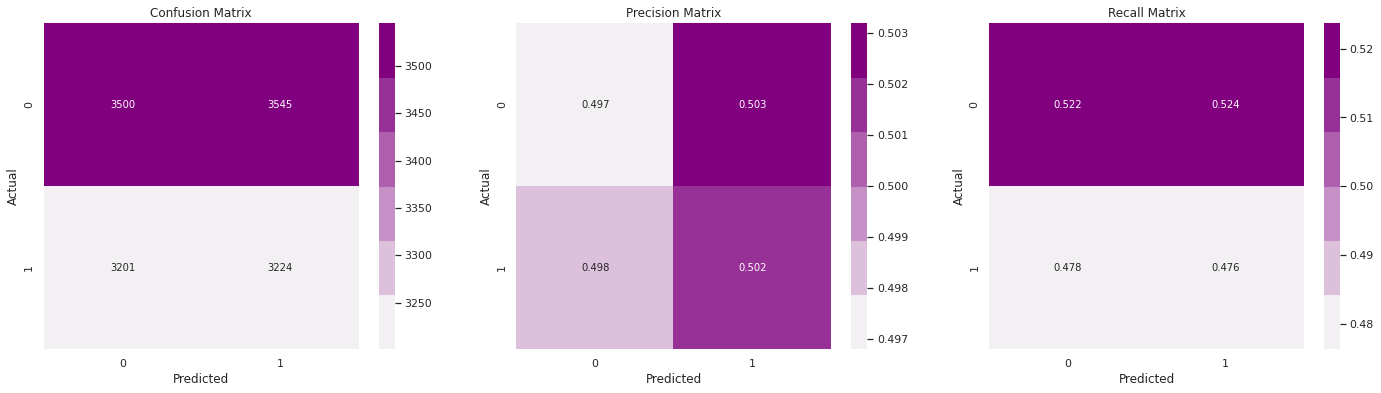

In [ ]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression with hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.6931471805599453
Regularization: L1	alpha = 0.0001	loss: 0.055248058434921594
Regularization: L1	alpha = 0.001	loss: 0.06807965052513151
Regularization: L1	alpha = 0.01	loss: 0.14447594490359128
Regularization: L1	alpha = 0.1	loss: 0.6061481301366349
Regularization: L1	alpha = 1	loss: 0.6931471805599453
Regularization: L1	alpha = 10	loss: 0.6931471805599454

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.04036282278401565
Regularization: L2	alpha = 0.0001	loss: 0.03919415983418278
Regularization: L2	alpha = 0.001	loss: 0.03391226543085906
Regularization: L2	alpha = 0.01	loss: 0.02836386463072672
Regularization: L2	alpha = 0.1	loss: 0.03799659432897051
Regularization: L2	alpha = 1	loss: 0.06792109550282734
Regularization: L2	alpha = 10	loss: 0.10971968955723198

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.040158226566289305
Regularization: ElasticNet	alpha = 0.0001	loss: 0.0370175997020

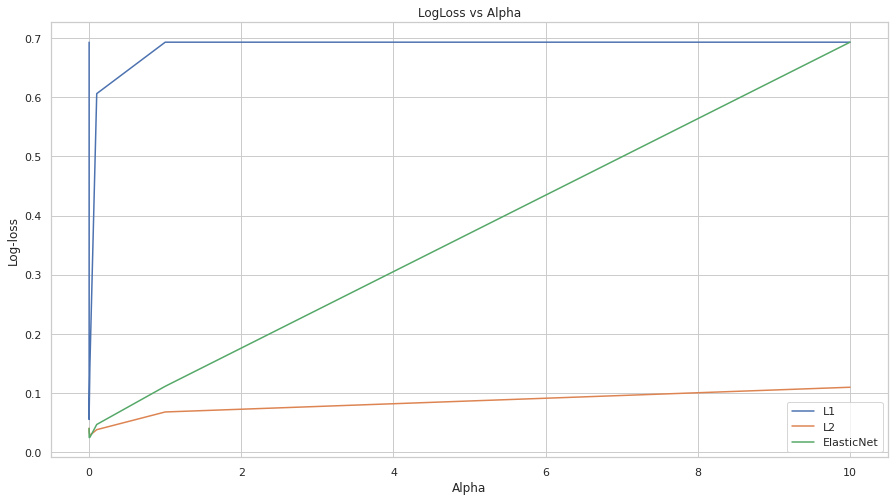

In [ ]:
# hyperparameter: alpha to iterate over
# list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

Log loss for best alpha on train data: 0.006997295573456191
Log loss for best alpha on test data: 0.02836386463072672




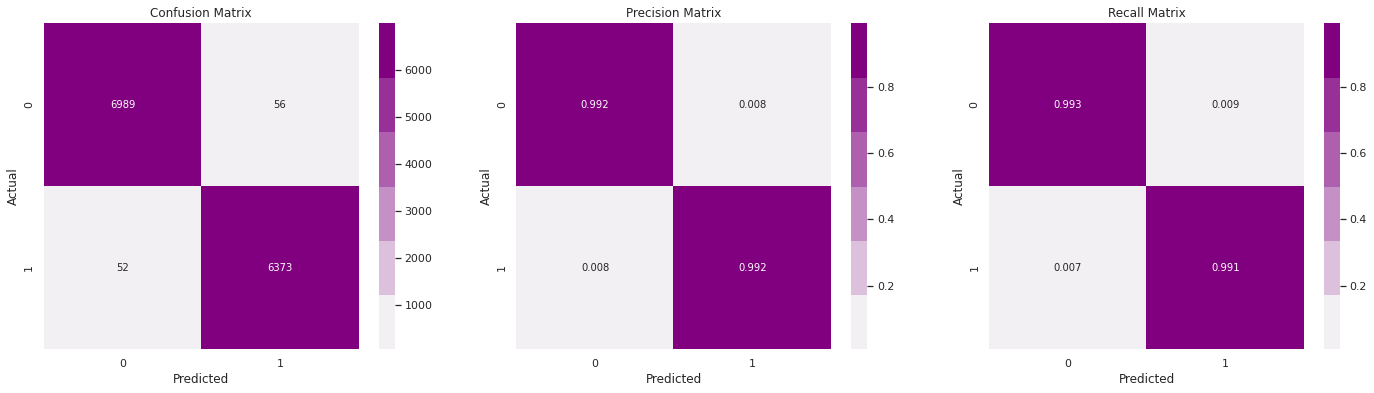

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(l2_logloss)]

# train SGDClassifier with best alpha regularization
sgd_clf_LR = SGDClassifier(loss='log', alpha=best_alpha, penalty='l2', n_jobs=-1, random_state=42)

# Train model
sgd_clf_LR.fit(model_train, train_labels)

# Initialize calibration model
cal_clf_LR = CalibratedClassifierCV(sgd_clf_LR)

# Fit calibration model
cal_clf_LR.fit(model_train, train_labels)

# Predict
predict_train = cal_clf_LR.predict_proba(model_train)
predict_test = cal_clf_LR.predict_proba(model_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

In [ ]:
# Dumping the model into a pickel file

pickle.dump(cal_clf_LR, open('/content/drive/My Drive/Fake News Detection/LR_model.pkl', 'wb'))

In [ ]:
# Convert probabilities to 0 or 1 and calculate accuracy
predicted_train = np.argmax(predict_train, axis=1)
predicted_test = np.argmax(predict_test, axis=1)

# Accuracy
train_score = accuracy_score(train_labels, predicted_train)
test_score = accuracy_score(test_labels, predicted_test)
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 0.9997262107568752
Test Accuracy: 0.9919821826280624


### Linear SVM with Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.6931471805599453
Regularization: L1	alpha = 0.0001	loss: 0.05343073451873225
Regularization: L1	alpha = 0.001	loss: 0.06515688181832942
Regularization: L1	alpha = 0.01	loss: 0.14087867849888527
Regularization: L1	alpha = 0.1	loss: 0.4840337021753924
Regularization: L1	alpha = 1	loss: 0.6901181469842532
Regularization: L1	alpha = 10	loss: 0.6931471805599454

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.0394157047116019
Regularization: L2	alpha = 0.0001	loss: 0.039092865935201754
Regularization: L2	alpha = 0.001	loss: 0.03698373865563064
Regularization: L2	alpha = 0.01	loss: 0.030442814917492355
Regularization: L2	alpha = 0.1	loss: 0.028281181506552434
Regularization: L2	alpha = 1	loss: 0.03920786260287278
Regularization: L2	alpha = 10	loss: 0.08220561425598422

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.03994104563248582
Regularization: ElasticNet	alpha = 0.0001	loss: 0.0377740093897

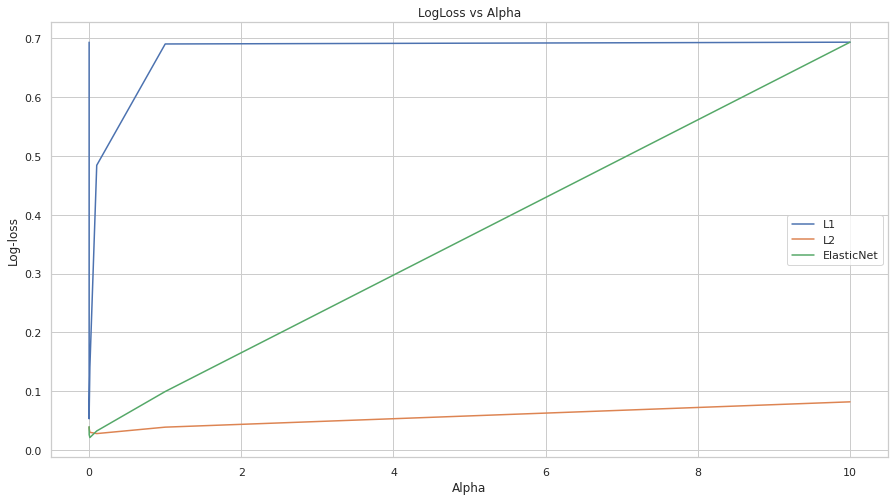

In [ ]:
# hyperparameter: alpha to iterate over
#  list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

Log loss for best alpha on train data: 0.015974990482393474
Log loss for best alpha on test data: 0.021573154122512962




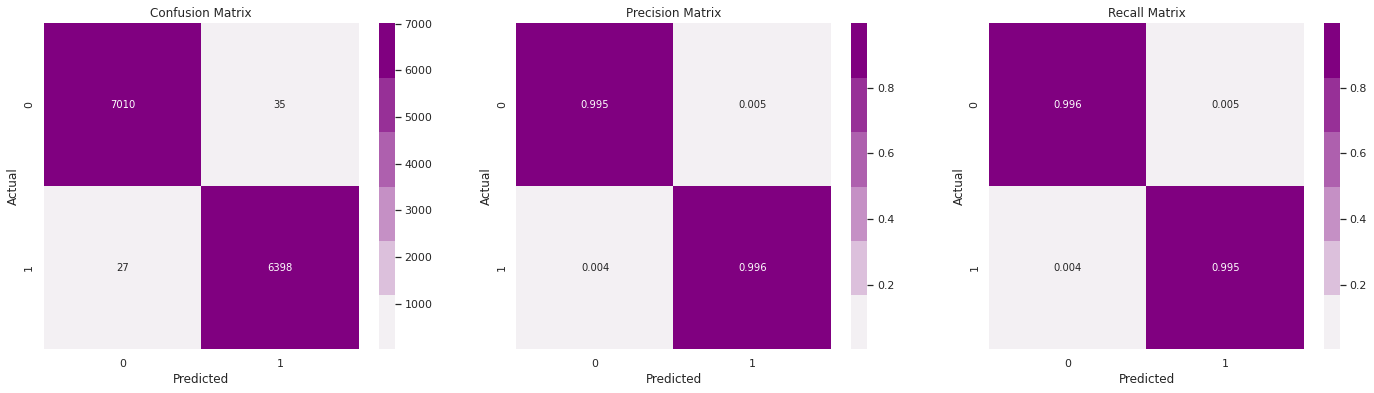

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(elasticnet_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf_SVM = SGDClassifier(loss='hinge', alpha=best_alpha, penalty='ElasticNet', n_jobs=-1, random_state=42)

# Train model
sgd_clf_SVM.fit(model_train, train_labels)

# Initialize calibration model
cal_clf_SVM = CalibratedClassifierCV(sgd_clf_SVM)

# Fit calibration model
cal_clf_SVM.fit(model_train, train_labels)

# Predict
predict_train = cal_clf_SVM.predict_proba(model_train)
predict_test = cal_clf_SVM.predict_proba(model_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

In [ ]:
# Dumping the model into a pickel file

pickle.dump(cal_clf_SVM, open('/content/drive/My Drive/Fake News Detection/SVM_model.pkl', 'wb'))

In [ ]:
# Evaluate 

predictions_train = sgd_clf_SVM.predict(model_train)
predictions_test = sgd_clf_SVM.predict(model_test)

accuracy_train = np.mean((train_labels == predictions_train).astype(np.float)) * 100.
accuracy_test = np.mean((test_labels == predictions_test).astype(np.float)) * 100.
print(f"Accuracy_train = {accuracy_train:.3f}")
print(f"Accuracy_test = {accuracy_test:.3f}")

Accuracy_train = 99.696
Accuracy_test = 99.458


### GDBT: XgBoost with Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6, 8]
n_estimators = [10, 100, 500, 1000]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_train, train_labels)

    # Predict on test data
    pred_prob = gbdt_clf.predict_proba(model_test)

    # Get log loss on training data
    pred_prob_training = gbdt_clf.predict_proba(model_train)
    loss_training = log_loss(train_labels, pred_prob_training)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

    # Print training and test loss for this iteration
    print('Train loss: {0} \tTest loss: {1}\n'.format(loss_training, loss))

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
Train loss: 0.2097401462081003 	Test loss: 0.2094571952941069

Running at depth: 2, n_estimators: 100
Train loss: 0.013913808957027369 	Test loss: 0.01530376039360325

Running at depth: 2, n_estimators: 500
Train loss: 0.002263175002634306 	Test loss: 0.008313662982736463

Running at depth: 2, n_estimators: 1000
Train loss: 0.0006128528344821754 	Test loss: 0.007867562817071254

Running at depth: 4, n_estimators: 10
Train loss: 0.20648148655710094 	Test loss: 0.2063322912688687

Running at depth: 4, n_estimators: 100
Train loss: 0.004325400921758933 	Test loss: 0.009761672288109566

Running at depth: 4, n_estimators: 500
Train loss: 0.00023354361721229005 	Test loss: 0.00867467475169819

Running at depth: 4, n_estimators: 1000
Train loss: 0.00013146174198031465 	Test loss: 0.009203101072989477

Running at depth: 6, n_estimators: 10
Train loss: 0.2045261425773726 	Test loss: 0.20484394849829082

Running at depth: 6, n_estimators: 100
Train loss: 0.0

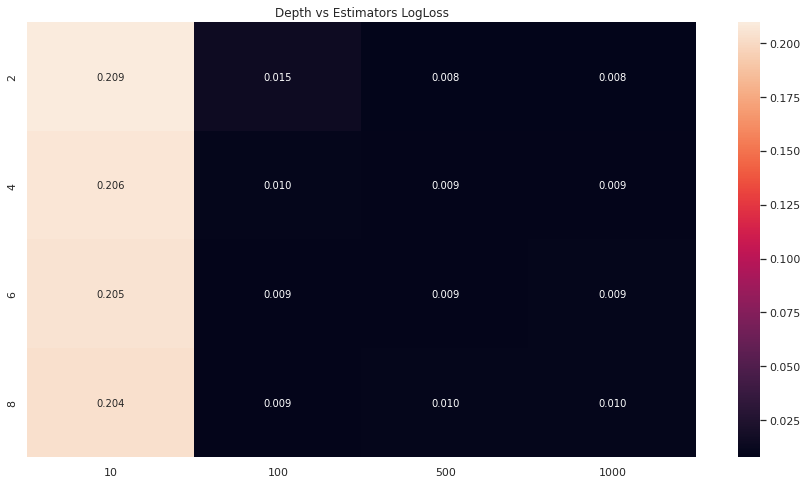

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.002263175002634306
Log loss for best alpha on test data: 0.008313662982736463




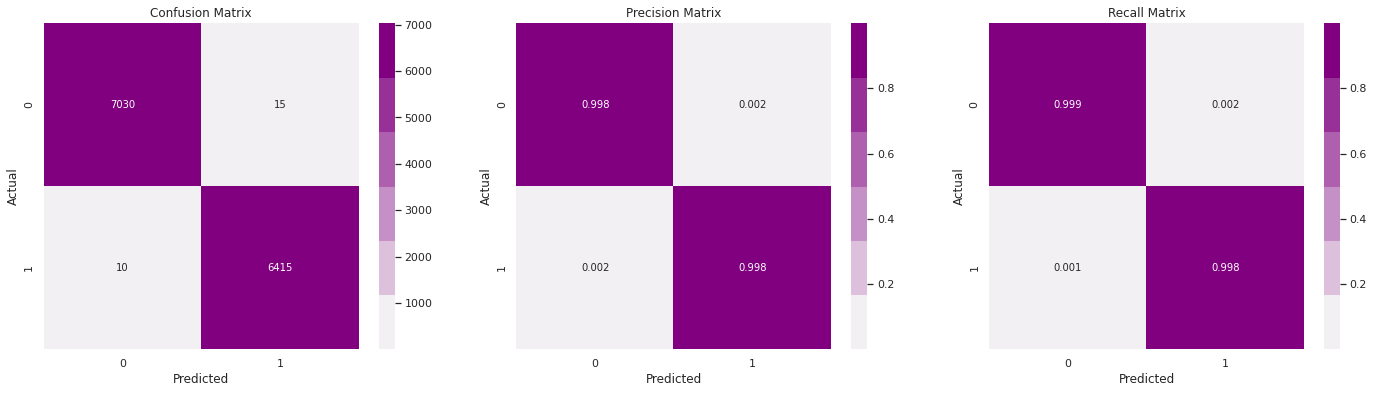

In [ ]:
# Setting best hyperparameters
# Not providing the best hyper parameters because it's overfitting

n_estimators= 500
max_depth= 2 

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_train, train_labels)

# Predict
predict_train = gbdt_clf.predict_proba(model_train)
predict_test = gbdt_clf.predict_proba(model_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

In [ ]:
# Dumping the model into a pickel file

pickle.dump(gbdt_clf, open('/content/drive/My Drive/Fake News Detection/GBDT_model.pkl', 'wb'))

In [ ]:
# Convert probabilities to 0 or 1 and calculate accuracy
predicted_train = np.argmax(predict_train, axis=1)
predicted_test = np.argmax(predict_test, axis=1)

# Accuracy
train_score = accuracy_score(train_labels, predicted_train)
test_score = accuracy_score(test_labels, predicted_test)
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 0.9997566317838891
Test Accuracy: 0.9981440237564959


### Random Forest with Hyperparameter tuning

In [ ]:
# list of hyperparameters to iterate over
max_depth = [4, 6, 8, 10]
n_estimators = [100, 500, 1000, 1500]

# list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = RandomForestClassifier(max_depth=depth, n_estimators=n, n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_train, train_labels)

    # Predict on test data
    pred_prob = gbdt_clf.predict_proba(model_test)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

  result_logloss.append(logloss)

Running at depth: 4, n_estimators: 100
Running at depth: 4, n_estimators: 500
Running at depth: 4, n_estimators: 1000
Running at depth: 4, n_estimators: 1500
Running at depth: 6, n_estimators: 100
Running at depth: 6, n_estimators: 500
Running at depth: 6, n_estimators: 1000
Running at depth: 6, n_estimators: 1500
Running at depth: 8, n_estimators: 100
Running at depth: 8, n_estimators: 500
Running at depth: 8, n_estimators: 1000
Running at depth: 8, n_estimators: 1500
Running at depth: 10, n_estimators: 100
Running at depth: 10, n_estimators: 500
Running at depth: 10, n_estimators: 1000
Running at depth: 10, n_estimators: 1500


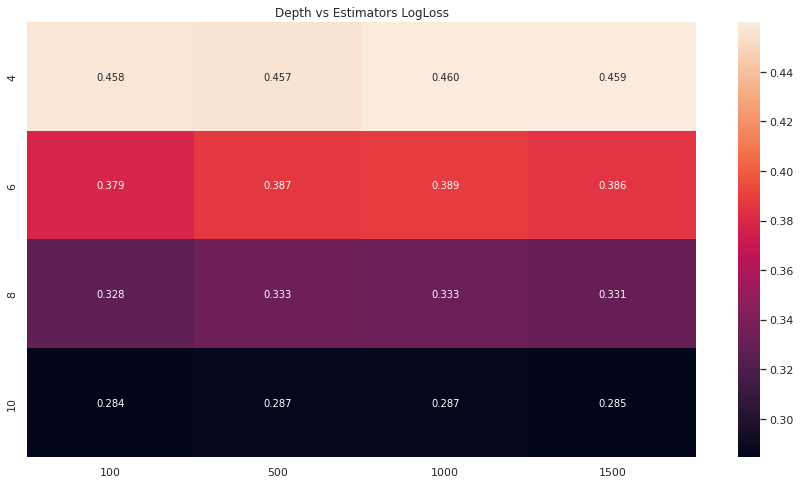

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

Log loss for best alpha on train data: 0.2733573332621843
Log loss for best alpha on test data: 0.2865878275625186




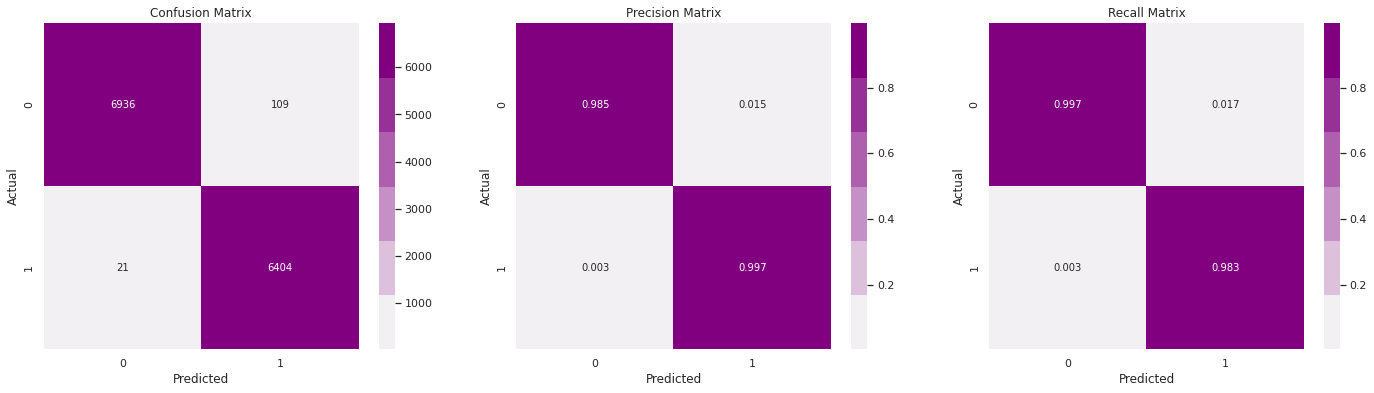

In [ ]:
# Setting best hyperparameters
n_estimators=100
max_depth= 10 

# Initialize model
rf_clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, criterion='gini', n_jobs=-1, random_state=42)

# Fitting on train data
rf_clf.fit(model_train, train_labels)

# Predict
predict_train = rf_clf.predict_proba(model_train)
predict_test = rf_clf.predict_proba(model_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

In [ ]:
# Dumping the model into a pickel file

pickle.dump(rf_clf, open('/content/drive/My Drive/Fake News Detection/RF_model.pkl', 'wb'))

In [ ]:
# Evaluate using the GBDT
predictions_train = rf_clf.predict(model_train)
predictions_test = rf_clf.predict(model_test)

accuracy_train = np.mean((train_labels == predictions_train).astype(np.float)) * 100.
accuracy_test = np.mean((test_labels == predictions_test).astype(np.float)) * 100.
print(f"Accuracy_train = {accuracy_train:.3f}")
print(f"Accuracy_test = {accuracy_test:.3f}")

Accuracy_train = 99.340
Accuracy_test = 99.035


In [ ]:
# Convert probabilities to 0 or 1 and calculate accuracy
predicted_train = np.argmax(predict_train, axis=1)
predicted_test = np.argmax(predict_test, axis=1)

# Accuracy
train_score = accuracy_score(train_labels, predicted_train)
test_score = accuracy_score(test_labels, predicted_test)
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 0.9933986371379898
Test Accuracy: 0.9903489235337788


# Finally Done with Training :